## Data analysis

In [1]:
#from utils import *
#from lin_GAN_penny_script import *
import torch
import torch.nn as nn
import tensorflow as tf
import numpy as np
import pandas as pd
from scipy.stats import f
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
import os
import random
import time
import datetime
from tqdm import tqdm
from sklearn import datasets
from torch.utils.data import Dataset, DataLoader
import fnmatch

In [2]:
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

In [3]:
# dataloader = torch.utils.data.DataLoader(rd, batch_size=1, shuffle=True, drop_last=True)

# for elem in dataloader:
#     plt.imshow(elem[0][0])

#show_images(GAN_imgs[0], 20)

#show_images(QGAN_imgs[100:150], 20)

In [4]:
# Plotting histogram probability distributions 

# linear_gan_synthetic = np.concatenate(GAN_imgs).reshape(len(GAN_imgs), 8, 8)
# reshaped_linear_gan_synthetic = linear_gan_synthetic.reshape(len(GAN_imgs)*64)
# linear_qgan_synthetic = np.concatenate(QGAN_imgs).reshape(len(QGAN_imgs), 8, 8)
# reshaped_linear_qgan_synthetic = linear_qgan_synthetic.reshape(len(QGAN_imgs)*64)
# real_data = np.concatenate(real_img).reshape(len(real_img), 8, 8)
# reshaped_real_data = real_data.reshape(len(real_data)*64)

# empty_dataframe = pd.DataFrame(columns=['Real data','GAN', 'QGAN'])
# df1 = pd.DataFrame(reshaped_real_data)
# df2 = pd.DataFrame(reshaped_linear_gan_synthetic)
# df3 = pd.DataFrame(reshaped_linear_qgan_synthetic)
# df = pd.concat([df1, df2, df3], 1)
# df.columns = ['Real data','GAN', 'QGAN']

# sns.displot(data = df, kind = 'kde')

In [5]:
def resize_data_one_hot(x, y, label, image_size, num_classes):

    arr, arr_input, labels = [], [], []

    for t, l in zip(x, y):
        if l in label:
            t = torch.tensor(t, dtype = torch.float32).reshape(image_size, image_size)
            t = t/16
            lab = torch.nn.functional.one_hot(torch.tensor(l), num_classes=num_classes)
            arr.append((t, lab))
            arr_input.append(t)
            labels.append(l)
    return arr, arr_input, labels


def split_train_test(real_data, idx, num_classes):

    train_data, test_data = [], []

    for i, (img, label) in enumerate(real_data):

        if i < idx:

            # one hot enoding for training labels
            #print(label)
            #lab = torch.nn.functional.one_hot(torch.tensor(label), num_classes=num_classes)
            #print('img shape train data: ', img.shape)
            train_data.append((img, label))
        
        else:
            
            #lab = torch.nn.functional.one_hot(torch.tensor(label), num_classes=num_classes)
            test_data.append((img, label))

    return train_data, test_data



def build_dataset(model_type, noise_dim, path, len_real_data, labels, num_classes, max_epoch):

    if model_type == 'Classical_linear':

        GAN_imgs, dataset, idx = [], [], 0      

        dirs = os.listdir(path)

        for elem in sorted(dirs):
            #print(elem)
            file = os.listdir(path+elem)
            #print(file)
            #print(torch.load(path+elem+'/lin_gen')) 

        # r=root, d=directories, f=files
        # for r, d, f in os.walk(path): 
        #     #print('directory: ', d)
        #     #print(f)                 
        #     for file in f:                 
        #         if file.endswith("lin_gen_epoch_*"):    

            #print(os.path.join(r, file))                     
            model = torch.load(path+elem+'/lin_gen')
            model.eval()


            for _ in range(500):      
        
                image = model(torch.rand(1, noise_dim)).view(8,8).cpu().detach()
                #print('img shape: ', image.shape)
                # plt.imshow(image, cmap='gray')
                # plt.show()
                # time.sleep(0.1)
                GAN_imgs.append(image)
                label = torch.nn.functional.one_hot(torch.tensor(labels[idx]), num_classes=num_classes)
                dataset.append((image, label))                    
                
            idx += 1

            #print('FINISH', len(GAN_imgs))
            

    elif model_type == 'Quantum_linear':

        GAN_imgs, dataset, idx = [], [], 0  
    
        dirs = os.listdir(path)

        for elem in sorted(dirs):
            #print(elem)
            file = os.listdir(path+elem)

            model = torch.load(path+elem+'/lin_q_gen')    
            model.eval()              

            #print(idx) 

            for _ in range(500):   

                image = model(torch.rand(1, noise_dim)).view(8,8).cpu().detach()
                
                GAN_imgs.append(image.shape)
                #print(labels[idx])
                label = torch.nn.functional.one_hot(torch.tensor(labels[idx]), num_classes=num_classes)
                dataset.append((image, label))
                
            idx += 1                
    
    else:

        print('Network typology not admitted.')

    return GAN_imgs, dataset




class Classificator(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 8, 3, padding = 'same')
        #self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(8, 16, 3)
        self.fc1 = nn.Linear(576, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, num_classes)

    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = torch.relu(self.conv2(x))
        #print(x.shape)
        x = torch.flatten(x,1) # flatten all dimensions except batch
        #print(x.shape)
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return torch.sigmoid(x)



def training_classification(classificator, train_dataloader, epochs, learning_rate, batch_size, path):

    optimizer = torch.optim.SGD(classificator.parameters(),lr=learning_rate)
    loss_fn = nn.CrossEntropyLoss()

    episode_loss = []
    tot_loss_mean = []

    with tqdm(range(epochs)) as tepochs:

        for epoch in tepochs:  

            running_loss = 0.0
            for i, data in enumerate(train_dataloader):

                #(train, label) = data
                #print(data[0].shape)
                #print(data[1].shape)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward + backward + optimize
                outputs = classificator(data[0].view(batch_size,1,8,8))#(data[0].size(0), -1))
                #print('Outputs training: ', outputs.shape)
                
                #if model_type == 'Classical_linear':
                label = data[1].float()

                # elif model_type == 'Quantum_linear':
                #     label = data[1].float()
                    
                # else:
                #     label = data[1].float()
                #print('Label: ', label.shape)

                loss = loss_fn(outputs, label)
                loss.backward()
                optimizer.step()

                episode_loss.append(loss.item())

                # print statistics
                running_loss += loss.item()
                
                tepochs.set_postfix({'Classificator loss' : loss.item()})
            
            tot_loss_mean.append(np.mean(episode_loss))

            torch.save(classificator.state_dict(), path + 'classificator.pt')

    return tot_loss_mean          


        
def evaluate_accuracy(classificator, test_dataloader, path):

    correct = 0
    total = 0

    #print(test_label_batch)

    with torch.no_grad():
        for data in test_dataloader:
            
            labels = data[1]
            #print('labels: ', labels)
            #print('Data:', data[0].shape)

            classificator.load_state_dict(torch.load(path + 'classificator.pt'))
            
            outputs = classificator(data[0].view(1,1,8,8))#.view(data.size(0), -1)
           
            act_label = np.argmax(labels) # act_label = 1 (index)
            #print('act labels: ', act_label)
            pred_label = np.argmax(outputs) # pred_label = 1 (index)
            #print('pred labels: ', pred_label)
            if(act_label == pred_label):
                correct += 1
            
            total += 1
    
    # print('correct: ', correct)
    # print('total: ', total)
    print('Accuracy score: ', correct / total)

    return correct / total 



def training_run(model_type, classificator, dataloader, real_dataloader, learning_rate, epochs, batch_size, reset_parameters=True):

    current_time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    if model_type == 'Classical_linear':
        
        save_path = 'torch_results/Classificator/GAN_data/' + current_time + '/'

    elif model_type == 'Quantum_linear':

        save_path = 'torch_results/Classificator/QGAN_data/' + current_time + '/'
    
    else:
        print('Model typology not admitted.')
    summary_writer = tf.summary.create_file_writer(save_path)

    loss_synthetic = training_classification(classificator, dataloader, epochs, learning_rate, batch_size, save_path)
    acc_synthetic = evaluate_accuracy(classificator, real_dataloader, save_path)


    if reset_parameters:
        for layer in classificator.children():
            if hasattr(layer, 'reset_parameters'):
                layer.reset_parameters()

    
    return acc_synthetic, loss_synthetic
    


def multiple_runs(runs, model_type, c_classificator, q_classificator, synthetic_dataloader, q_synthetic_dataloader, real_dataloader, learning_rate, epochs, batch_size, reset_parameters=True):

    acc_tot = []
    q_acc_tot = []
    loss_tot = []
    q_loss_tot = []

    for run in range(runs):

        print(f'---------------------------------------- RUN {run+1} ----------------------------------------')
        
        print('Classical GAN training: ')
        classical_accuracy, classical_loss = training_run(model_type[0], c_classificator, synthetic_dataloader, real_dataloader, learning_rate, epochs, batch_size, reset_parameters=True)
        #print(classical_accuracy)

        print('Quantum GAN training: ')
        quantum_accuracy, quantum_loss = training_run(model_type[1], q_classificator, q_synthetic_dataloader, real_dataloader, learning_rate, epochs, batch_size, reset_parameters=True)

        acc_tot.append(classical_accuracy)
        q_acc_tot.append(quantum_accuracy)
        loss_tot.append(classical_loss)
        q_loss_tot.append(quantum_loss)

    c_acc_mean = np.mean(acc_tot)
    c_acc_std = np.std(acc_tot)
    q_acc_mean = np.mean(q_acc_tot)    
    q_acc_std = np.std(q_acc_tot)

    c_loss_mean = np.mean(loss_tot)
    c_loss_std = np.std(loss_tot)
    q_loss_mean = np.mean(q_loss_tot)    
    q_loss_std = np.std(q_loss_tot)

    delta_acc = [np.abs(acc_tot[i]-q_acc_tot[i]) for i in range(len(acc_tot))]

    dict = {'GAN_data_accuracy': [acc_tot], 'QGAN_data_accuracy': [q_acc_tot]}  
       
    df = pd.DataFrame(dict)         
    # saving the dataframe 
    df.to_csv(f'torch_results/Metrics/Classification_accuracies_{2}_labels.csv')

    return acc_tot, q_acc_tot, delta_acc, classical_loss, quantum_loss#, c_acc_mean, c_acc_std, q_acc_mean, q_acc_std, c_loss_std, , q_loss_std


def show_images(data, n_samples):

    plt.figure(figsize=(8,2))

    for i in range(n_samples):
        image = data[i][0]#.reshape(8, 8)
        plt.subplot(1,n_samples,i+1)
        plt.axis('off')
        plt.imshow(image.numpy(), cmap='gray')
        
    plt.show()

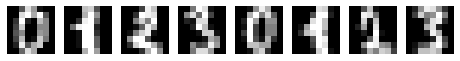

(1797, 720, 576, 144)

In [6]:
noise_dim = 5
image_size = 8
model_type = ['Classical_linear', 'Quantum_linear']
labels = [0,1,2,3]
num_classes = len(labels)
runs = 10
epochs = 20
batch_size = 4
learning_rate = 0.01
#num_classes = 2

# Showing real data
digits, targets = datasets.load_digits(return_X_y =True)
digits = digits.reshape(len(digits), 8, 8)

# Selecting only specific labels
real_data, real_img, test_labels = resize_data_one_hot(digits, targets, label=labels, image_size=image_size, num_classes=num_classes)

# Splitting train-test data (one-hot encoding included)
idx = int(len(real_data)*0.8)
train_data, test_data = split_train_test(real_data, idx, num_classes=num_classes)
test_label = targets[:idx]
show_images(real_data, 8)
len(digits), len(real_data), len(train_data), len(test_data)

In [7]:
#-------------------------------------------------------- Making inference --------------------------------------------------------
len_real_data = len(real_data)

# Bulding synthetic classical dataset (one-hot encoding included)
path = "torch_results/GAN/GAN_linear/"
GAN_imgs, synthetic_classical_data = build_dataset(model_type[0], noise_dim, path, len_real_data, labels, num_classes, max_epoch=2)

# # Bulding synthetic quantum dataset (one-hot encoding included)
q_path = "torch_results/QGAN/QGAN_linear/"
QGAN_imgs, synthetic_quantum_data = build_dataset(model_type[1], noise_dim, q_path, len_real_data, labels, num_classes, max_epoch=2)

In [8]:
len(synthetic_classical_data), len(synthetic_quantum_data)

(2000, 2000)

In [9]:
#plt.imshow(synthetic_quantum_data[2000][0]), synthetic_quantum_data[2000][1]

In [10]:
#plt.imshow(synthetic_classical_data[2000][0]), synthetic_classical_data[2000][1]

In [11]:
#plt.imshow(real_data[3][0]), real_data[3][1]

In [12]:
synthetic_dataloader = DataLoader(synthetic_classical_data, batch_size=batch_size, shuffle=True, drop_last=True)
q_synthetic_dataloader = DataLoader(synthetic_quantum_data, batch_size=batch_size, shuffle=True, drop_last=True)

real_dataloader = DataLoader(real_data, shuffle=True)
train_dataloader = DataLoader(train_data, batch_size = batch_size, shuffle=True, drop_last=True)
test_dataloader = DataLoader(test_data, shuffle=True)

# for img, l in real_dataloader:
#     print(l)

In [13]:
r_classificator = Classificator(num_classes)
c_classificator = Classificator(num_classes)
q_classificator = Classificator(num_classes)

In [14]:
r_path = "torch_results"
r_loss = training_classification(r_classificator, train_dataloader, epochs, learning_rate, batch_size, r_path)
evaluate_accuracy(r_classificator, test_dataloader, r_path)

100%|██████████| 20/20 [00:10<00:00,  1.95it/s, Classificator loss=1.21]


Accuracy score:  0.5625


0.5625

In [15]:
acc_tot, q_acc_tot, delta_acc, c_loss, q_loss = multiple_runs(runs, model_type, c_classificator, q_classificator, synthetic_dataloader, q_synthetic_dataloader,
                                                              real_dataloader, learning_rate, epochs, batch_size, reset_parameters=True) 

2023-02-02 17:59:46.990047: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-02-02 17:59:46.990082: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2023-02-02 17:59:46.990097: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (vt-bozzololu): /proc/driver/nvidia/version does not exist
2023-02-02 17:59:46.990328: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


---------------------------------------- RUN 1 ----------------------------------------
Classical GAN training: 


100%|██████████| 20/20 [00:35<00:00,  1.79s/it, Classificator loss=0.744]


Accuracy score:  0.8277777777777777
Quantum GAN training: 


100%|██████████| 20/20 [00:35<00:00,  1.77s/it, Classificator loss=0.875]


Accuracy score:  0.6611111111111111
---------------------------------------- RUN 2 ----------------------------------------
Classical GAN training: 


100%|██████████| 20/20 [00:40<00:00,  2.05s/it, Classificator loss=0.744]


Accuracy score:  0.8722222222222222
Quantum GAN training: 


100%|██████████| 20/20 [00:42<00:00,  2.12s/it, Classificator loss=0.809]


Accuracy score:  0.6541666666666667
---------------------------------------- RUN 3 ----------------------------------------
Classical GAN training: 


100%|██████████| 20/20 [00:41<00:00,  2.07s/it, Classificator loss=0.744]


Accuracy score:  0.7041666666666667
Quantum GAN training: 


100%|██████████| 20/20 [00:36<00:00,  1.81s/it, Classificator loss=0.745]


Accuracy score:  0.7444444444444445
---------------------------------------- RUN 4 ----------------------------------------
Classical GAN training: 


100%|██████████| 20/20 [00:36<00:00,  1.80s/it, Classificator loss=0.875]


Accuracy score:  0.6444444444444445
Quantum GAN training: 


100%|██████████| 20/20 [00:36<00:00,  1.85s/it, Classificator loss=0.744]


Accuracy score:  0.75
---------------------------------------- RUN 5 ----------------------------------------
Classical GAN training: 


100%|██████████| 20/20 [00:43<00:00,  2.17s/it, Classificator loss=0.744]


Accuracy score:  0.85
Quantum GAN training: 


100%|██████████| 20/20 [00:39<00:00,  2.00s/it, Classificator loss=0.744]


Accuracy score:  0.775
---------------------------------------- RUN 6 ----------------------------------------
Classical GAN training: 


100%|██████████| 20/20 [00:35<00:00,  1.79s/it, Classificator loss=0.744]


Accuracy score:  0.8583333333333333
Quantum GAN training: 


100%|██████████| 20/20 [00:37<00:00,  1.89s/it, Classificator loss=0.744]


Accuracy score:  0.7930555555555555
---------------------------------------- RUN 7 ----------------------------------------
Classical GAN training: 


100%|██████████| 20/20 [00:48<00:00,  2.43s/it, Classificator loss=0.875]


Accuracy score:  0.6277777777777778
Quantum GAN training: 


100%|██████████| 20/20 [00:53<00:00,  2.69s/it, Classificator loss=0.747]


Accuracy score:  0.7708333333333334
---------------------------------------- RUN 8 ----------------------------------------
Classical GAN training: 


100%|██████████| 20/20 [00:36<00:00,  1.82s/it, Classificator loss=1.01] 


Accuracy score:  0.6333333333333333
Quantum GAN training: 


100%|██████████| 20/20 [00:36<00:00,  1.82s/it, Classificator loss=0.744]


Accuracy score:  0.6638888888888889
---------------------------------------- RUN 9 ----------------------------------------
Classical GAN training: 


100%|██████████| 20/20 [00:36<00:00,  1.84s/it, Classificator loss=0.744]


Accuracy score:  0.8569444444444444
Quantum GAN training: 


100%|██████████| 20/20 [00:36<00:00,  1.85s/it, Classificator loss=0.744]


Accuracy score:  0.7833333333333333
---------------------------------------- RUN 10 ----------------------------------------
Classical GAN training: 


100%|██████████| 20/20 [00:46<00:00,  2.31s/it, Classificator loss=0.744]


Accuracy score:  0.8805555555555555
Quantum GAN training: 


100%|██████████| 20/20 [00:37<00:00,  1.85s/it, Classificator loss=0.744]


Accuracy score:  0.8


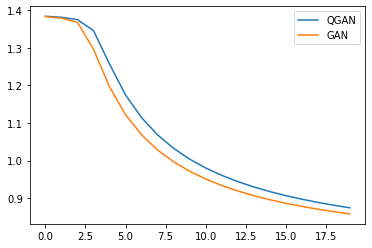

In [16]:
plt.plot(np.arange(len(c_loss)), q_loss, label='QGAN')
plt.plot(np.arange(len(c_loss)), c_loss, label='GAN')
plt.legend()
plt.show()

In [17]:
acc_tot, q_acc_tot

([0.8277777777777777,
  0.8722222222222222,
  0.7041666666666667,
  0.6444444444444445,
  0.85,
  0.8583333333333333,
  0.6277777777777778,
  0.6333333333333333,
  0.8569444444444444,
  0.8805555555555555],
 [0.6611111111111111,
  0.6541666666666667,
  0.7444444444444445,
  0.75,
  0.775,
  0.7930555555555555,
  0.7708333333333334,
  0.6638888888888889,
  0.7833333333333333,
  0.8])

In [18]:
c_acc_2_features = [0.9694444444444444,0.9805555555555555,0.9666666666666667,0.9861111111111112,0.9833333333333333,0.9527777777777777,0.9611111111111111,0.9777777777777777,0.9666666666666667,0.975]

q_acc_2_features = [0.9861111111111112,0.9972222222222222,0.9888888888888889,0.9888888888888889,0.9833333333333333,0.9916666666666667,0.9916666666666667,0.9916666666666667,0.9888888888888889,
0.9861111111111112]

c_acc_3_features = [0.9385474860335196, 0.9366852886405959,0.9497206703910615,0.9608938547486033,0.9199255121042831,0.8938547486033519,0.9273743016759777,0.9608938547486033,0.9478584729981379,
0.9478584729981379]

q_acc_3_features = [0.8733705772811918,0.7299813780260708,0.8342644320297952,0.8156424581005587,0.8919925512104283,0.8528864059590316,0.813780260707635,0.7970204841713222,0.7690875232774674,
0.8081936685288641]

c_acc_3_features = []

q_acc_3_features = []

# c_acc_4_features = [0.8680555555555556,0.8416666666666667,0.8375,0.6416666666666667,0.85,0.8458333333333333,0.8333333333333334,0.8972222222222223,0.8166666666666667,0.8263888888888888]

# q_acc_4_features = [0.6611111111111111,0.6541666666666667,0.7444444444444445,0.75,0.775,0.7930555555555555,0.7708333333333334,0.6638888888888889,0.7833333333333333,0.8]

c_acc_4_features = [0.8277777777777777,
  0.8722222222222222,
  0.7041666666666667,
  0.6444444444444445,
  0.85,
  0.8583333333333333,
  0.6277777777777778,
  0.6333333333333333,
  0.8569444444444444,
  0.8805555555555555]

q_acc_4_features = [0.6611111111111111,
  0.6541666666666667,
  0.7444444444444445,
  0.75,
  0.775,
  0.7930555555555555,
  0.7708333333333334,
  0.6638888888888889,
  0.7833333333333333,
  0.8]

c_acc_5_features = [0.8745837957824639,
  0.7136514983351832,
  0.8601553829078802,
  0.8701442841287459,
  0.8867924528301887,
  0.8912319644839067,
  0.8357380688124306,
  0.8923418423973363,
  0.8934517203107658,
  0.6781354051054383]

q_acc_5_features = [0.7491675915649278,
  0.7225305216426193,
  0.5671476137624861,
  0.5804661487236404,
  0.5560488346281909,
  0.4794672586015538,
  0.5793562708102109,
  0.537180910099889,
  0.41731409544950054,
  0.3895671476137625]

In [19]:
c_acc_final = [c_acc_2_features, c_acc_3_features, c_acc_4_features, c_acc_5_features]
q_acc_final = [q_acc_2_features, q_acc_3_features, q_acc_4_features, q_acc_5_features]

In [22]:
def accuracy_boxplot(c_acc_final, q_acc_final, labels):

    fig, ax = plt.subplots(figsize=(12, 6), facecolor='oldlace')

    #for i in range(num_tests):
    
    boxes = ax.boxplot(c_acc_final, patch_artist=True, showmeans = False, showfliers=False, widths = 0.12, labels = labels)
    for box in boxes["boxes"]:
        box.set(facecolor = "green")

    boxes = ax.boxplot(q_acc_final, patch_artist=True, showmeans = False, showfliers=False, widths = 0.12, labels = labels)
    for box in boxes["boxes"]:
        box.set(facecolor = "palegreen")

    fig.text(0.92, 0.73, f'GAN linear\nGen: 134 params\nDisc: 5127 params', backgroundcolor='green', color='black', weight='roman')
    fig.text(0.92, 0.63, f'QGAN linear\nGen: 120 params\nDisc: 5127 params', backgroundcolor='palegreen', color='black', weight='roman')
    # fig.text(0.92, 0.53, f'QGAN linear\nGen: 120 params\nDisc: 5127 params', backgroundcolor='darkkhaki', color='black', weight='roman')
    # fig.text(0.92, 0.43, f'QGAN linear\nGen: 120 params\nDisc: 5127 params', backgroundcolor='palegoldenrod', color='black', weight='roman')

    ax.set_xlabel('Number of labels', fontsize=16)
    ax.set_ylabel('Accuracy score', fontsize=16)
    plt.grid()
    plt.title(f"Accuracy classification score - Handwritten 8x8 dataset", fontsize=18)
    #plt.savefig(f'torch_results/Metrics/Classification_accuracies_2_3_labels.png')
    plt.show()

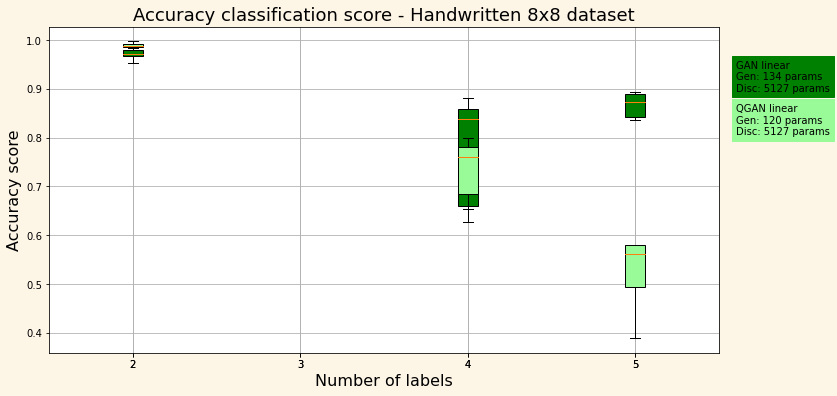

In [23]:
boxplot = accuracy_boxplot(c_acc_final, q_acc_final, [2,3,4,5])
boxplot

In [ ]:
# dict = {'Real_data_acc': [acc_real], 'GAN_data_acc': [acc_synthetic], 'QGAN_data_acc': [acc_q_synthetic]}  
       
# df = pd.DataFrame(dict) 
    
# # saving the dataframe 
# df.to_csv(f'torch_results/Metrics/Classification_accuracies_{len(labels)}_labels.csv')


# data = {'GAN 204 params':acc_synthetic, 'QGAN 120 params':acc_q_synthetic}
# courses = list(data.keys())
# values = list(data.values())

# label1 = [np.round(acc_synthetic, 3)]
# label2 = [np.round(acc_q_synthetic, 3)]
  
# fig = plt.figure(figsize = (13, 9))
 
# # creating the bar plot
# plt.bar(courses, values, color = ['blue', 'red'], data = [acc_synthetic, acc_q_synthetic])
# plt.text(x = -0.06 , y = data['GAN 204 params'] + 0.5, s = label1[0], size = 15)
# plt.text(x = 0.94 , y = data['QGAN 120 params'] + 0.6, s = label2[0], size = 15) 
# plt.ylabel("Accuracy", fontsize=18)
# plt.title(f"Accuracy classification score - Handwritten 8x8 dataset - {len(labels)} labels", fontsize=18)
# plt.savefig(f'torch_results//Metrics/Classification_accuracies_{len(labels)}_labels.png')
# plt.show()


# plt.figure(figsize=(10, 7))
# #plt.plot(np.arange(epochs), classical_loss_real[:epochs], label = 'Train: real data\nTest:real data')
# plt.plot(np.arange(epochs), classical_loss_synthetic[:epochs], label = 'Train: synthetic classical data\nTest: real data')
# plt.plot(np.arange(epochs), quantum_loss_synthetic[:epochs], label = 'Train: synthetic quantum data\nTest: real data')
# plt.title(f'Classification training loss - {len(labels)} labels')
# plt.legend()
# plt.savefig(f'torch_results//Metrics/Classification_loss_{len(labels)}_labels.png')
# plt.show()
